In [1]:
# !pip install biopython
!pip install --upgrade --no-cache-dir biopython
!pip install rdkit-pypi
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install -q torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 40.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 60.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 21.7 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 63.4 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:00a 0:00:01


In [ ]:
import numpy as np
import pandas as pd 
import itertools
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader
from torch_geometric.data import Batch
import torch.nn as nn
from sklearn.decomposition import PCA
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import torch
import pickle
from torch.utils.data import DataLoader, Subset, random_split
import seaborn as sns
from utils import plot_hyperparameter_results, plot_hyperparameter_results_enhanced


In [142]:
protein_features=np.load('/kaggle/input/drug-virus-features/protein_features.npy')
pIC50=np.load('/kaggle/input/drug-virus-features/pIC50.npy')
with open("/kaggle/input/drug-virus-features/drug_graphs.pkl", "rb") as f:
    drug_graphs = pickle.load(f)



In [163]:
total_size = len(protein_features)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

all_indices = list(range(total_size))
train_indices, val_indices, test_indices = random_split(
    all_indices, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)
train_protein = protein_features[train_indices] 



In [144]:
def drug_graph_to_data(drug_graph):
    mol_size, nodes, edges, edges_type = drug_graph
    x = torch.tensor(nodes, dtype=torch.float)  # [num_nodes, node_features]
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()  # [2, num_edges]
    edge_attr = torch.tensor(edges_type, dtype=torch.float).unsqueeze(1)  # [num_edges, 1]
    
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

In [ ]:
class DrugProteinDataset(torch.utils.data.Dataset):
    def __init__(self, protein_features, drug_graphs, pIC50_values):
        self.protein_features = protein_features
        self.drug_graphs = drug_graphs
        self.pIC50_values = pIC50_values
    
    def __len__(self):
        return len(self.pIC50_values)
    
    def __getitem__(self, idx):
        protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)
        drug_graph = drug_graph_to_data(self.drug_graphs[idx])
        pIC50_value = torch.tensor(self.pIC50_values[idx], dtype=torch.float)
        return protein_feature, drug_graph, pIC50_value

def custom_collate(batch):
    protein_feats = torch.stack([item[0] for item in batch])  # [batch_size, protein_feature_dim]
    drug_graphs = [item[1] for item in batch]                 
    labels = torch.stack([item[2] for item in batch])         # [batch_size]

    batch_drug_graphs = Batch.from_data_list(drug_graphs)     

    return protein_feats, batch_drug_graphs, labels


In [ ]:
class DrugTargetGNN(nn.Module):
    def __init__(self, node_feature_dim=78, protein_feature_dim=50, hidden_dim=128):
        super().__init__()
        self.conv1 = GCNConv(node_feature_dim, node_feature_dim)
        self.conv2 = GCNConv(node_feature_dim, node_feature_dim*2)
        self.conv3 = GCNConv(node_feature_dim*2, node_feature_dim*4)

        
        self.lineargraph = nn.Linear(node_feature_dim*4, hidden_dim)
        
        self.protein_mlp = nn.Sequential(
            nn.Linear(protein_feature_dim, protein_feature_dim*2),
            nn.ReLU(),
            nn.Linear(protein_feature_dim*2, protein_feature_dim*4),
            nn.ReLU(),
            nn.Linear(protein_feature_dim*4, hidden_dim)
            
        )
        
        #  combined features
        self.final_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1)  # regression output for pIC50
        )

        
    def forward(self, protein_feat, drug_graph):
        x, edge_index,edge_attr = drug_graph.x, drug_graph.edge_index,drug_graph.edge_attr
        x = F.relu(self.conv1(x, edge_index,edge_attr))
        x = F.relu(self.conv2(x, edge_index,edge_attr))
        x = F.relu(self.conv3(x, edge_index,edge_attr))
        
        x = global_mean_pool(x, drug_graph.batch)  # [batch_size, hidden_dim]
        x = F.relu(self.lineargraph(x))

        
        # protein feature embedding
        p = self.protein_mlp(protein_feat)  # [batch_size, hidden_dim]
        
        # combine embeddings
        combined = torch.cat([x, p], dim=1)
        out = self.final_mlp(combined)
        return out.squeeze()  # [batch_size]

In [147]:

def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for protein_feats, drug_graphs, values in dataloader:
            protein_feats = protein_feats.to(device)
            drug_graphs = drug_graphs.to(device)
            values = values.to(device)

            outputs = model(protein_feats, drug_graphs)
            all_preds.append(outputs.cpu())
            all_labels.append(values.cpu())
         
    preds = torch.cat(all_preds).numpy()
   
    values = torch.cat(all_labels).numpy()

    mse = mean_squared_error(values, preds)
    rmse = mse ** 0.5
    pearson_corr, _ = pearsonr(values, preds)

    return {
        "MSE": mse,
        "RMSE": rmse,
        "Pearson": pearson_corr
    }


In [148]:
hidden_dims = [64, 128, 256]
batch_sizes = [64, 128, 256]
learning_rates = [1e-3, 5e-4, 1e-4]
pca_components = [30, 50, 70]

In [ ]:
results = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Iterate over all combinations
for hidden_dim, batch_size, lr, n_comp in itertools.product(hidden_dims, batch_sizes, learning_rates, pca_components):
    print(f"Testing: hidden_dim={hidden_dim}, batch_size={batch_size}, lr={lr}, n_components={n_comp}")
    
    pca = PCA(n_components=n_comp)
    pca.fit(train_protein)
    protein_pca = pca.transform(protein_features)
    protein_pca = torch.tensor(protein_pca, dtype=torch.float32)
    
    dataset = DrugProteinDataset(protein_pca, drug_graphs, pIC50)
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)
    
    model = DrugTargetGNN(node_feature_dim=78, protein_feature_dim=n_comp, hidden_dim=hidden_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    model.train()
    for epoch in range(20):
        total_loss = 0
        for protein_feat, drug_graph, values in train_loader:
            protein_feat = protein_feat.to(device)
            drug_graph = drug_graph.to(device)
            values = values.to(device)
            optimizer.zero_grad()
            outputs = model(protein_feat, drug_graph)
            loss = criterion(outputs, values)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    
    val_metrics = evaluate(model, val_loader, device)
    
    results.append({
        'hidden_dim': hidden_dim,
        'batch_size': batch_size,
        'learning_rate': lr,
        'n_components': n_comp,
        'MSE': val_metrics['MSE'],
        'RMSE': val_metrics['RMSE'],
        'Pearson': val_metrics['Pearson']
    })

results_df = pd.DataFrame(results)

Testing: hidden_dim=64, batch_size=64, lr=0.001, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=64, lr=0.001, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=64, lr=0.001, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=64, lr=0.0005, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=64, lr=0.0005, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=64, lr=0.0005, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=64, lr=0.0001, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=64, lr=0.0001, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=64, lr=0.0001, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=128, lr=0.001, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=128, lr=0.001, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=128, lr=0.001, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=128, lr=0.0005, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=128, lr=0.0005, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=128, lr=0.0005, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=128, lr=0.0001, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=128, lr=0.0001, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=128, lr=0.0001, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=256, lr=0.001, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=256, lr=0.001, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=256, lr=0.001, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=256, lr=0.0005, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=256, lr=0.0005, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=256, lr=0.0005, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=256, lr=0.0001, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=256, lr=0.0001, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=64, batch_size=256, lr=0.0001, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=64, lr=0.001, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=64, lr=0.001, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=64, lr=0.001, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=64, lr=0.0005, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=64, lr=0.0005, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=64, lr=0.0005, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=64, lr=0.0001, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=64, lr=0.0001, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=64, lr=0.0001, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=128, lr=0.001, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=128, lr=0.001, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=128, lr=0.001, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=128, lr=0.0005, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=128, lr=0.0005, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=128, lr=0.0005, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=128, lr=0.0001, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=128, lr=0.0001, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=128, lr=0.0001, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=256, lr=0.001, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=256, lr=0.001, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=256, lr=0.001, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=256, lr=0.0005, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=256, lr=0.0005, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=256, lr=0.0005, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=256, lr=0.0001, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=256, lr=0.0001, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=128, batch_size=256, lr=0.0001, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=64, lr=0.001, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=64, lr=0.001, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=64, lr=0.001, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=64, lr=0.0005, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=64, lr=0.0005, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=64, lr=0.0005, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=64, lr=0.0001, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=64, lr=0.0001, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=64, lr=0.0001, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=128, lr=0.001, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=128, lr=0.001, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=128, lr=0.001, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=128, lr=0.0005, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=128, lr=0.0005, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=128, lr=0.0005, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=128, lr=0.0001, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=128, lr=0.0001, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=128, lr=0.0001, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=256, lr=0.001, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=256, lr=0.001, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=256, lr=0.001, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=256, lr=0.0005, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=256, lr=0.0005, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=256, lr=0.0005, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=256, lr=0.0001, n_components=30


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=256, lr=0.0001, n_components=50


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Testing: hidden_dim=256, batch_size=256, lr=0.0001, n_components=70


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


In [ ]:
sns.set(style="whitegrid")

hyperparameters = {
'hidden_dim' : [64, 128, 256],
'batch_size' : [64, 128, 256],
'learning_rate' : [1e-3, 5e-4, 1e-4],
'n_components' : [30, 50, 70]
}

metrics = ['MSE', 'RMSE', 'Pearson']


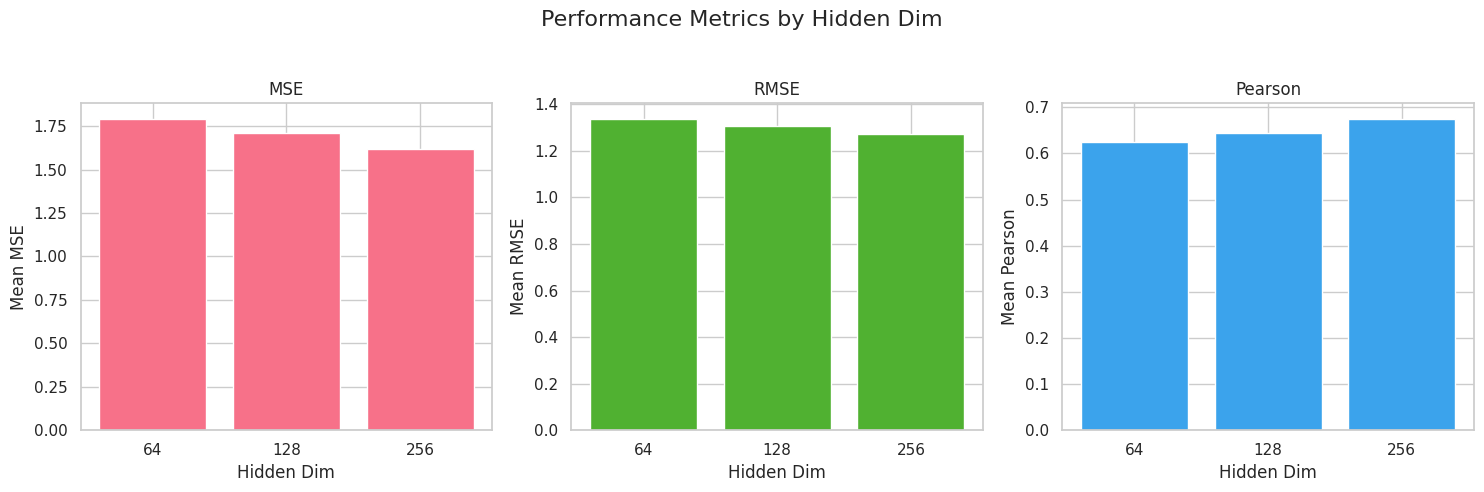

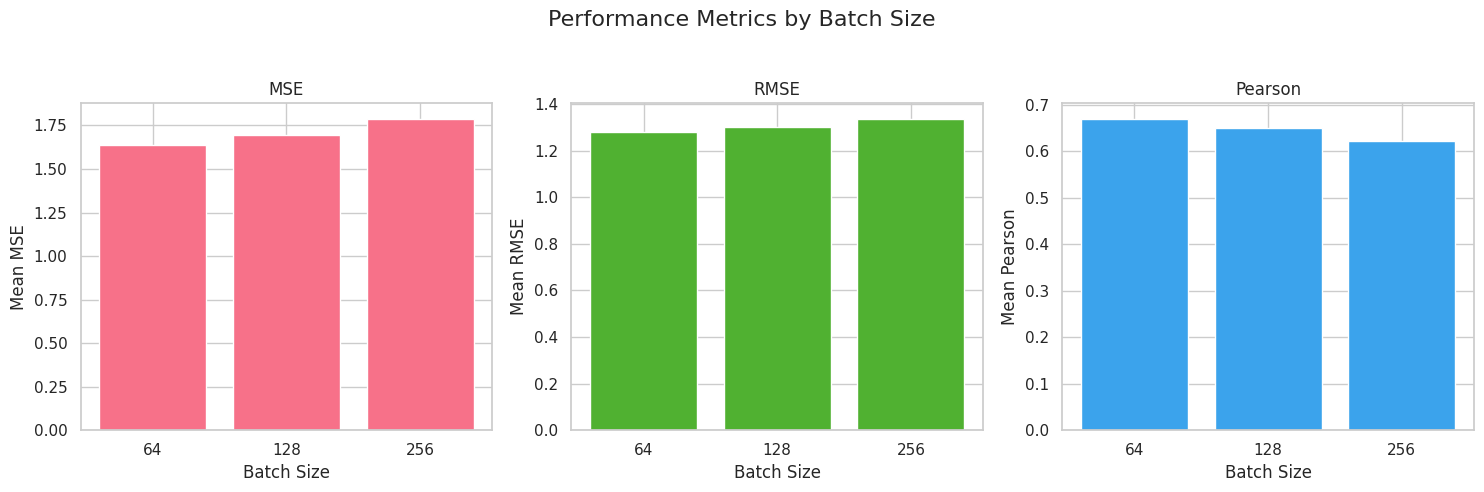

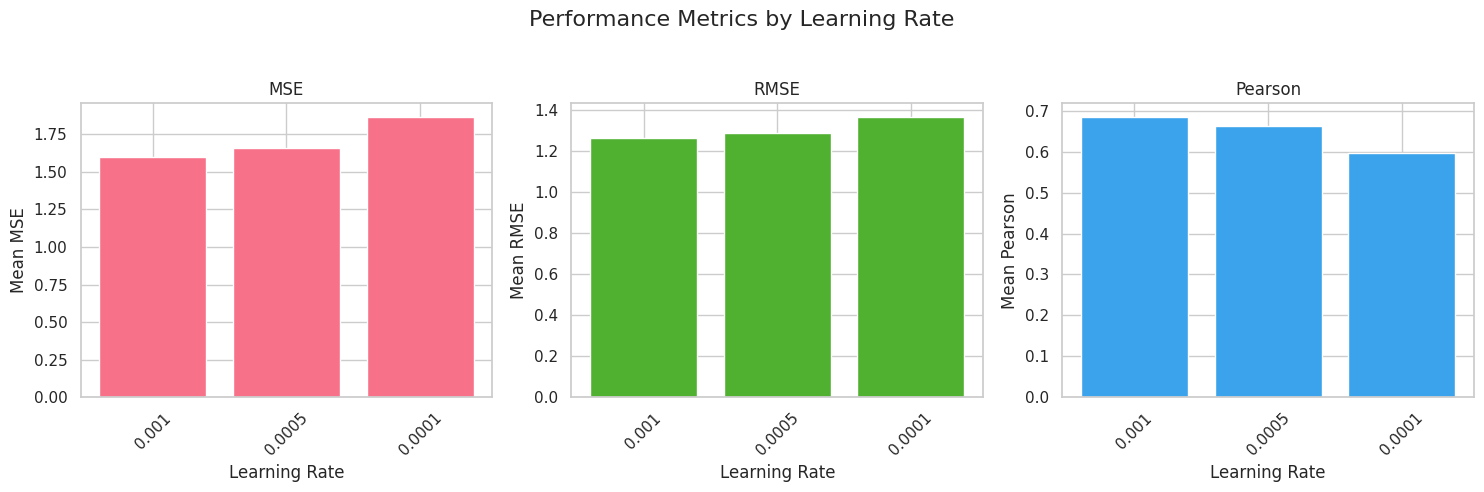

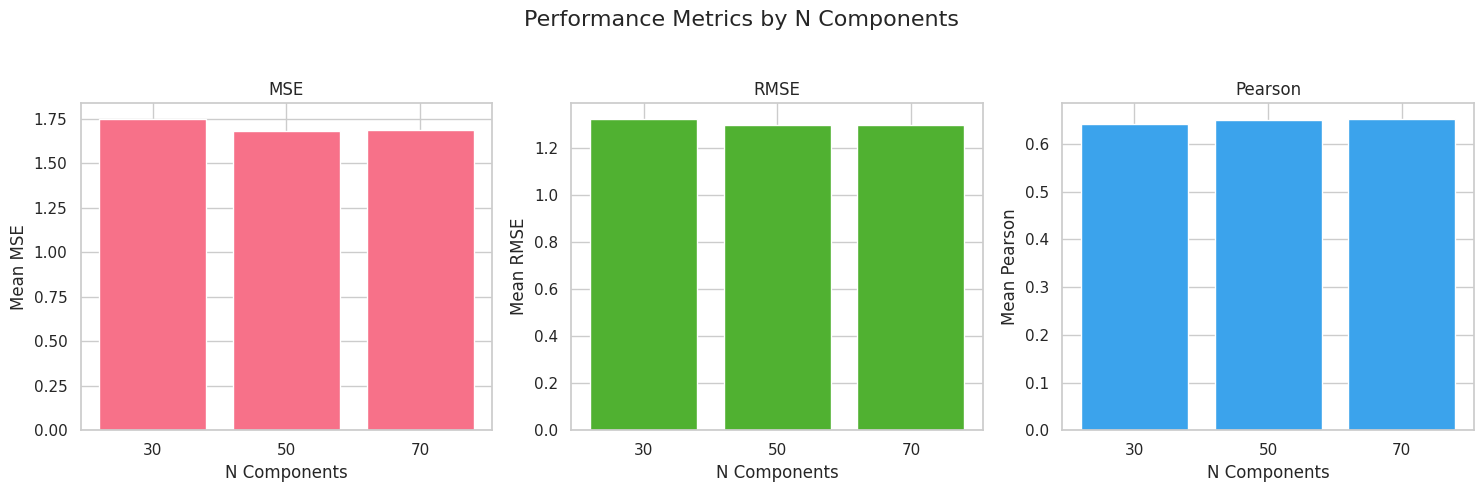

Best Hyperparameters:
{'hidden_dim': 256.0, 'batch_size': 64.0, 'learning_rate': 0.001, 'n_components': 50.0}
Best Metrics:
{'MSE': 1.2654045820236206, 'RMSE': 1.1249020321893017, 'Pearson': 0.753842976389115}


In [ ]:

for hyperparam, values in hyperparameters.items():
    plot_hyperparameter_results(metrics,hyperparam, values, results_df)

best_row = results_df.loc[results_df['RMSE'].idxmin()]
print("Best Hyperparameters:")
print(best_row[['hidden_dim', 'batch_size', 'learning_rate', 'n_components']].to_dict())
print("Best Metrics:")
print(best_row[['MSE', 'RMSE', 'Pearson']].to_dict())

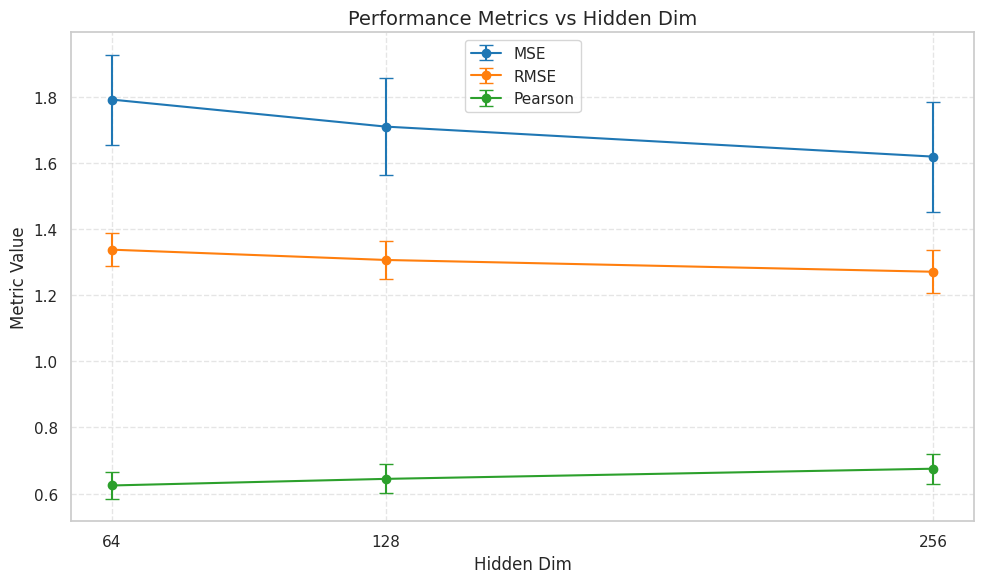

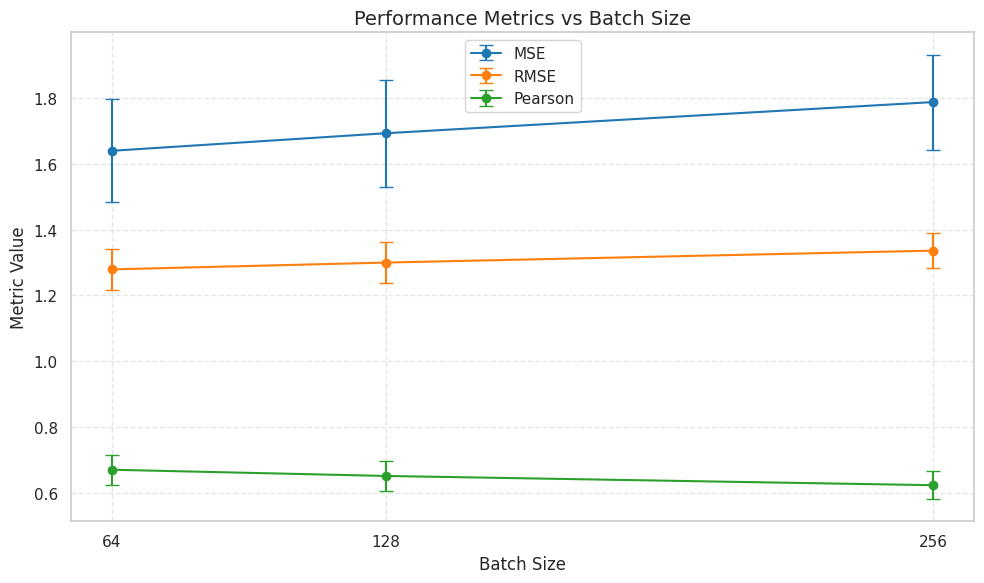

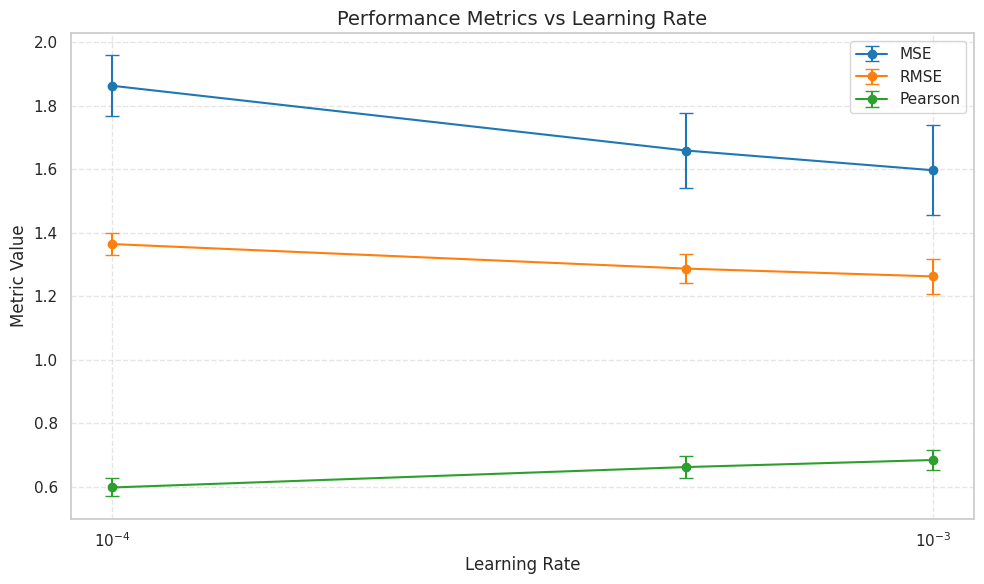

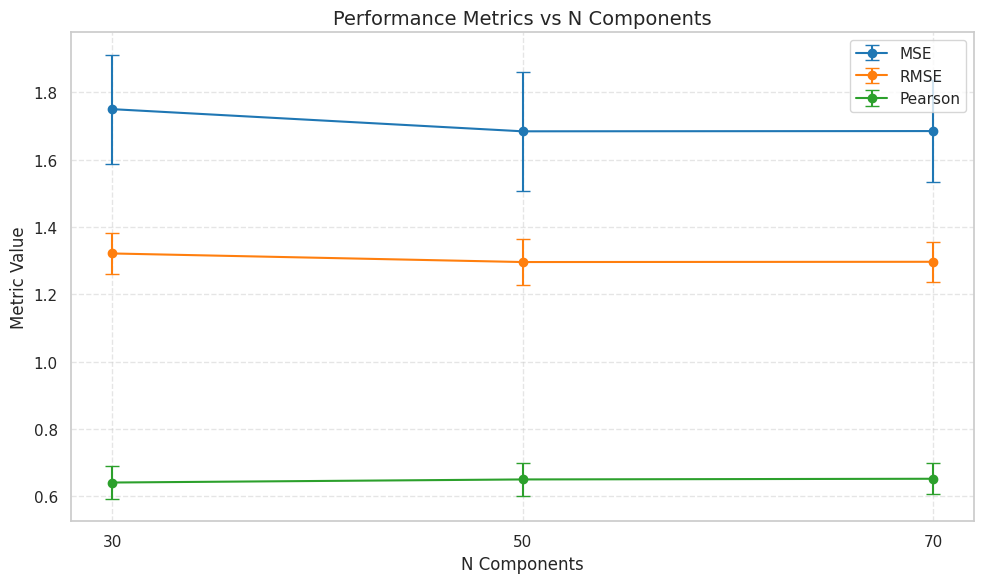

In [ ]:

for hyperparam, values in hyperparameters.items():
    plot_hyperparameter_results_enhanced(metrics,hyperparam, values, results_df)


In [ ]:
pca = PCA(n_components=int(best_row['n_components']))
pca.fit(train_protein)  # still fit only on training features
protein_pca = pca.transform(protein_features)
protein_pca = torch.tensor(protein_pca, dtype=torch.float32)

dataset = DrugProteinDataset(protein_pca, drug_graphs, pIC50)

train_val_indices = train_indices + val_indices
train_val_dataset = Subset(dataset, train_val_indices)
test_dataset = Subset(dataset, test_indices)

train_val_loader = DataLoader(
    train_val_dataset,
    batch_size=int(best_row['batch_size']),
    shuffle=True,
    collate_fn=custom_collate
)

test_loader = DataLoader(
    test_dataset,
    batch_size=int(best_row['batch_size']),
    shuffle=False,
    collate_fn=custom_collate
)

model = DrugTargetGNN(
    node_feature_dim=78,
    protein_feature_dim=int(best_row['n_components']),
    hidden_dim=int(best_row['hidden_dim'])
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_row['learning_rate'])
criterion = nn.MSELoss()

# retrain on train + val
print("Retraining on Train + Validation set...")
model.train()
for epoch in range(20):
    total_loss = 0
    for protein_feat, drug_graph, values in train_val_loader:
        protein_feat = protein_feat.to(device)
        drug_graph = drug_graph.to(device)
        values = values.to(device)
        optimizer.zero_grad()
        outputs = model(protein_feat, drug_graph)
        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

print("\nEvaluating on Test set...")
test_metrics = evaluate(model, test_loader, device)
print("Test Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")


Retraining on Train + Validation set...


<ipython-input-145-a969ade95676>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_feature = torch.tensor(self.protein_features[idx], dtype=torch.float)


Epoch 1, Loss: 807.0329
Epoch 2, Loss: 532.2789
Epoch 3, Loss: 508.2299
Epoch 4, Loss: 483.2224
Epoch 5, Loss: 468.4497
Epoch 6, Loss: 454.1916
Epoch 7, Loss: 440.0958
Epoch 8, Loss: 426.8316
Epoch 9, Loss: 413.6415
Epoch 10, Loss: 394.3818
Epoch 11, Loss: 387.0028
Epoch 12, Loss: 375.7385
Epoch 13, Loss: 365.6981
Epoch 14, Loss: 353.7295
Epoch 15, Loss: 347.4015
Epoch 16, Loss: 348.7204
Epoch 17, Loss: 336.7333
Epoch 18, Loss: 321.8331
Epoch 19, Loss: 315.7744
Epoch 20, Loss: 311.2228

Evaluating on Test set...
Test Metrics:
MSE: 1.3072
RMSE: 1.1433
Pearson: 0.7502
